In [1]:
import numpy as np
import os
import configparser

import cv2
import random


from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras import models
from keras.models import model_from_json

import sys
sys.path.insert(0, './lib/')
from help_functions import *
#function to obtain data for training/testing (validation)
from extract_patches import get_data_training
from model_lib import *


Using TensorFlow backend.
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

## Model init block


## Load Configuration block


In [2]:
config = configparser.RawConfigParser()
config.read('conj_configuration.txt')

path_imgs = config.get('data paths', 'conj_path_img') # training data
path_ground_truth = config.get('data paths', 'conj_path_ground') #training label
name_experiment = config.get('experiment name', 'name') # save folder

num_epochs = int(config.get('training settings', 'num_epochs')) # train epoch
batch_size = int(config.get('training settings', 'batch_size')) # batch size

fine_tuning_flag = config.get('fine tuning', 'fine_tuning') # is fine tuning? If you wanr to use retina-pretrain data -> True
pretrained_dir = config.get('fine tuning', 'pretrained_dir') # retina-pretrain path

best_last = config.get('testing settings', 'best_last') # use best weights? last weights?

name_experiment = 'result/'+'conjunctival_result/' +name_experiment
print(name_experiment)

result/conjunctival_result/20_03_20_test01


## Prepare conj data block

### Data information  
    ch : 1ch (gray level)  
    size : All diffent. shit  
    information : Conjunctival data from slit lamp. (just one person.)  

In [3]:
img_shape_list = []
img_list= []
ground_list =[]

# get image's size
# image shape -> H, W, C 
for count, filename in enumerate(sorted(os.listdir(path_imgs)), start=1):
    if filename.startswith(".ipynb") == False:
        #print('Enter {} to select {}'.format(count, filename))
        tempImg = cv2.imread(path_imgs + filename)
        #print('[DEBUG] shape of imgs : ', np.shape(tempImg), '\n')
        img_list.append(tempImg)
    
for count, filename in enumerate(sorted(os.listdir(path_ground_truth)), start=1):
    if filename.startswith(".ipynb") == False:
        #print('Enter {} to select {}'.format(count, filename))
        tempImg = cv2.imread(path_ground_truth + filename,0)
        #print('[DEBUG] shape of ground truth : ', np.shape(tempImg),'\n')
        ground_list.append(tempImg)
        
img_list = np.array(img_list)
ground_list = np.array(ground_list)

print(np.shape(img_list))
print(np.shape(ground_list))


#show_on_jupyter(img_list[8], color = 'gray')
#show_on_jupyter(ground_list[8],color = 'gray')

(45, 2336, 3504, 3)
(45, 2336, 3504)


In [4]:
if os.path.isdir('./'+name_experiment) == False:
    os.mkdir('./'+name_experiment)
else:
    print('already exist the folder in this path : {}'.format('./'+name_experiment))

already exist the folder in this path : ./result/conjunctival_result/20_03_20_test01


In [5]:
def augmentations(patches,masks,angle,ratio = 0.1):
    '''
    patches
        range [0.0, 1.0]
        
    ratio
        determine augmentation ratio (add noise, add blur)
        
    3 combination
        1. gaussian noise
        2. rotation
        3. gaussian noise + rotation
    
    '''
    sampling_num = int(len(patches) * ratio)
    augmentation_patches = patches.transpose(0,2,3,1)
    augmentation_masks = masks.transpose(0,2,3,1)
    #print('augmentation shape : ', augmentation_patches)
    
    h,w = augmentation_patches.shape[1], augmentation_patches.shape[2]
    
    sampling_list = random.sample(range(len(patches)), sampling_num)
    s_cnt = 0
    
    print('[Augmentation function] patches shape : ',np.shape(patches))
    print('[Augmentation function] augmentation patches shape : ',np.shape(augmentation_patches))
    print('[Augmentation function] augmentation patches masks shape : ',np.shape(augmentation_masks))
    
    for i in range(sampling_num):
        choice_num = random.randint(0,1)
        
        if choice_num ==0:
            #print('[Augmentation loop] aug patches shape : ',np.shape(augmentation_patches[sampling_list[s_cnt]]))
            pass
            #augmentation_patches[sampling_list[s_cnt]] = add_noise(augmentation_patches[sampling_list[s_cnt]])
            
        elif choice_num ==1:
            #print('[Augmentation loop] aug patches shape : ',np.shape(augmentation_patches[sampling_list[s_cnt]]))
            augmentation_patches[sampling_list[s_cnt]],augmentation_masks[sampling_list[s_cnt]] = add_rotate(augmentation_patches[sampling_list[s_cnt]],augmentation_masks[sampling_list[s_cnt]],angle,h,w)
            
        elif choice_num ==2:
            #print('[Augmentation loop] aug patches shape : ',np.shape(augmentation_patches[sampling_list[s_cnt]]))
            augmentation_patches[sampling_list[s_cnt]] = add_noise(augmentation_patches[sampling_list[s_cnt]])
            augmentation_patches[sampling_list[s_cnt]],augmentation_masks[sampling_list[s_cnt]] = add_rotate(augmentation_patches[sampling_list[s_cnt]],augmentation_masks[sampling_list[s_cnt]],angle,h,w)  
           
        
        elif choice_num ==3:
            augmentation_patches[sampling_list[s_cnt]] = add_contrast(augmentation_patches[sampling_list[s_cnt]])
        
        elif choice_num ==4:
            augmentation_patches[sampling_list[s_cnt]] = add_contrast(augmentation_patches[sampling_list[s_cnt]])
            augmentation_patches[sampling_list[s_cnt]] = add_noise(augmentation_patches[sampling_list[s_cnt]])
        elif choice_num ==5:
            augmentation_patches[sampling_list[s_cnt]] = add_contrast(augmentation_patches[sampling_list[s_cnt]])
            augmentation_patches[sampling_list[s_cnt]],augmentation_masks[sampling_list[s_cnt]] = add_rotate(augmentation_patches[sampling_list[s_cnt]],augmentation_masks[sampling_list[s_cnt]],angle,h,w)
        elif choice_num ==6:
            augmentation_patches[sampling_list[s_cnt]] = add_contrast(augmentation_patches[sampling_list[s_cnt]])
            augmentation_patches[sampling_list[s_cnt]] = add_noise(augmentation_patches[sampling_list[s_cnt]])
            augmentation_patches[sampling_list[s_cnt]],augmentation_masks[sampling_list[s_cnt]] = add_rotate(augmentation_patches[sampling_list[s_cnt]],augmentation_masks[sampling_list[s_cnt]],angle,h,w)  
            
            
        s_cnt +=1
        
    augmentation_patches = augmentation_patches.transpose(0,3,1,2)
    augmentation_masks = augmentation_masks.transpose(0,3,1,2)
    
    return augmentation_patches, augmentation_masks
    

def add_noise(patches):
    '''
    patches
        range [0.0,1.0]
        
    not change image's order
    '''
    rand_num = random.randint(1,4)
    mean = 0.0   # some constant
    std = 0.00    # some constant (standard deviation)
    std = std + (rand_num * 0.01)

    noisy_img = patches + (np.random.normal(mean, std, patches.shape))
    noisy_img_clipped = np.clip(noisy_img, 0.0, 1.0)
    
    return noisy_img_clipped

def add_rotate(mat,masks, angle ,h,w):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """
    cnt =0 
    height, width = (h,w) # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape
    angle = random.randint(-angle,angle)
    
    mask_ch = masks.shape[-1]
    rotated_masks = np.zeros((h,w,mask_ch))
    
    #print('mask shape : ', np.shape(rotated_masks))

        
    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (width, height))
    for i in range(mask_ch):
        rotated_masks[:,:,i] = cv2.warpAffine(masks[:,:,i], rotation_mat, (width, height))
    
    #print('mat shape : ', np.shape(rotated_mat))
    #print('mask shape : ', np.shape(rotated_masks))
    rotated_mat = np.expand_dims(rotated_mat,-1)
    
    return rotated_mat, rotated_masks

    
def add_blur(patches):
    kernel_size_list = [3,5]
    rand_num = random.randint(0,1)
    
    blur_patches = cv2.GaussianBlur(patches,(kernel_size_list[rand_num],kernel_size_list[rand_num]), cv2.BORDER_DEFAULT)
    blur_patches = np.expand_dims(blur_patches, axis=-1)
    return blur_patches

def add_contrast(patches):
    rand_num = random.uniform(0.8,1.3)
    rand_gamma= round(rand_num,2)

## Data preprocessing

In [6]:
def conj_preprocessing(img_list):
    img_len, img_list_h, img_list_w = np.shape(img_list)[0],np.shape(img_list)[1], np.shape(img_list)[2]
    preprocessed_img = np.zeros((img_len, img_list_h, img_list_w))
    pre_img = img_list.copy()
    
    for i in range(len(img_list)):
        '''
        RGB to gray
        '''
        
        #preprocessed_img[i] = preprocessed_img[i][:,:,0] * 0.299 + preprocessed_img[i][:,:,1]* 0.587+preprocessed_img[i][:,:,2]*0.114
        print(np.shape(preprocessed_img[i]))
        print(np.shape(pre_img[i][:,:,1]))
        
        preprocessed_img[i] = pre_img[i][:,:,1]
        #DEBUG block
        #show_on_jupyter(preprocessed_img[i],'gray')
        #print('[1]', np.shape(preprocessed_img[i]))
        
        '''
        Dataset_normlaized
        '''
        imgs_normalized = np.empty(preprocessed_img[i].shape)
        imgs_std = np.std(preprocessed_img[i])
        imgs_mean = np.mean(preprocessed_img[i])
        preprocessed_img[i] = (preprocessed_img[i]-imgs_mean)/imgs_std
        preprocessed_img[i] = ((preprocessed_img[i] - np.min(preprocessed_img[i])) / (np.max(preprocessed_img[i])-np.min(preprocessed_img[i])))*255
    
        #show_on_jupyter(preprocessed_img[i],'gray')
        #print('[2]', np.shape(preprocessed_img[i]))
        '''
        Clahe eqaulized
        
        '''
        #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        #preprocessed_img[i] = clahe.apply(np.array(preprocessed_img[i], dtype = np.uint8))
        
        #show_on_jupyter(preprocessed_img[i],'gray')
        #print('[3]', np.shape(preprocessed_img[i]))
        '''
        Adjust gamma
        
        '''
        #gamma = 1.2
        
        #invGamma = 1.0 / gamma
        #table = np.array([((j / 255.0) ** invGamma) * 255 for j in np.arange(0, 256)]).astype("uint8")
        # apply gamma correction using the lookup table
        #preprocessed_img[i] = cv2.LUT(np.array(preprocessed_img[i], dtype = np.uint8), table)
        #print('[4]', np.shape(preprocessed_img[i]))
        #show_on_jupyter(preprocessed_img[i],'gray')
        
        preprocessed_img[i] = preprocessed_img[i] / 255.
        #show_on_jupyter(preprocessed_img[i],'gray')
        #print(np.max(preprocessed_img[i]))
        #print('[5]', np.shape(preprocessed_img[i]))
    return preprocessed_img

# img shape -> H, W, C
print(np.shape(img_list))
prerprocessed_img_list = conj_preprocessing(img_list)


(45, 2336, 3504, 3)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336, 3504)
(2336

In [7]:
print(np.shape(prerprocessed_img_list[1]))

(2336, 3504)


In [8]:
def extract_random(full_imgs,full_masks, patch_h,patch_w, num_patches):
    
    patches = np.empty((num_patches, 1 , patch_h, patch_w))
    patches_masks = np.empty((num_patches, 1 , patch_h, patch_w))
    
    print('[extract random] patches shape : {}'.format(patches.shape))
    
    
    for i in range(len(full_imgs)):  # loop, number of image samples
        
        img_h = full_imgs[i].shape[0]
        img_w = full_imgs[i].shape[1]

        patch_per_img =int(num_patches / len(full_imgs)) #ex, 48 / 20
        
        #print('[extract random] patches per full image : {}'.format(patch_per_img))
        
        iter_total =0 #iter over the total number of patches (num_patches)
        k =0
        
        while k<patch_per_img: #iter, number of patch per img
            x_center = random.randint(0+int(patch_w/2) , img_w-int(patch_w/2))
            y_center = random.randint(0+int(patch_w/2) , img_h-int(patch_w/2))
            #print('[extract random] x_center : {}'.format(x_center))
            #print('[extract random] y_center : {}'.format(y_center))
            
            
            patch = full_imgs[i][y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)] #cropping
            patch_mask = full_masks[i][y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)]
            #print('[extract random] patch y : {} to {}'.format(y_center-int(patch_h/2),y_center+int(patch_h/2) ))
            #print('[extract random] patch size : {}'.format(np.shape(patch)))
            #show_on_jupyter(patch,'gray')
            #show_on_jupyter(patch_mask,'gray')
            
            # 여기 이상한데 shape 확인
            # 해당 부분에서 자연스럽게 ch-first 로 바뀌어야 함
            #print('patch shape : ', np.shape(patch))
            #print(np.shape(patches[iter_total]))
            patches[iter_total,0]=patch
            patches_masks[iter_total,0]=patch_mask
            iter_total +=1   #total
            k+=1  #per full_img
            
    return patches, patches_masks

save_path = name_experiment
if os.path.isdir(save_path) == False:
    os.mkdir(save_path)
else:
    print('already exist the folder in this path : {}'.format(save_path))

    
# <===== Extract random patch ======>

patches_imgs_train, patches_masks_train = extract_random(prerprocessed_img_list, ground_list,
                        patch_h = int(config.get('data attributes', 'patch_height')),
                        patch_w = int(config.get('data attributes', 'patch_width')),
                        num_patches = int(config.get('training settings', 'num_subimgs')))

patches_imgs_train,patches_masks_train = augmentations(patches_imgs_train,patches_masks_train,20,0.3)

already exist the folder in this path : result/conjunctival_result/20_03_20_test01
[extract random] patches shape : (200000, 1, 64, 64)
[Augmentation function] patches shape :  (200000, 1, 64, 64)
[Augmentation function] augmentation patches shape :  (200000, 64, 64, 1)
[Augmentation function] augmentation patches masks shape :  (200000, 64, 64, 1)


120
[group images func] prev data shape  : (120, 1, 64, 64)
[group images func] after data shape :  (120, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image :  (1600, 320, 1)
data shape :  (1600, 320, 1)
<PIL.Image.Image image mode=L size=320x1600 at 0x7FE91E6A0208>
file name :  ./result/conjunctival_result/20_03_20_test01/sample_input_imgs
[group images func] prev data shape  : (120, 1, 64, 64)
[group images func] after data shape :  (120, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image :  (1600, 320, 1)
data shape :  (1600, 320, 1)
<PIL.Image.Image image mode=L size=320x1600 at 0x7FE91E674D30>
file name :  ./result/conjunctival_result/20_03_20_test01/sample_input_masks


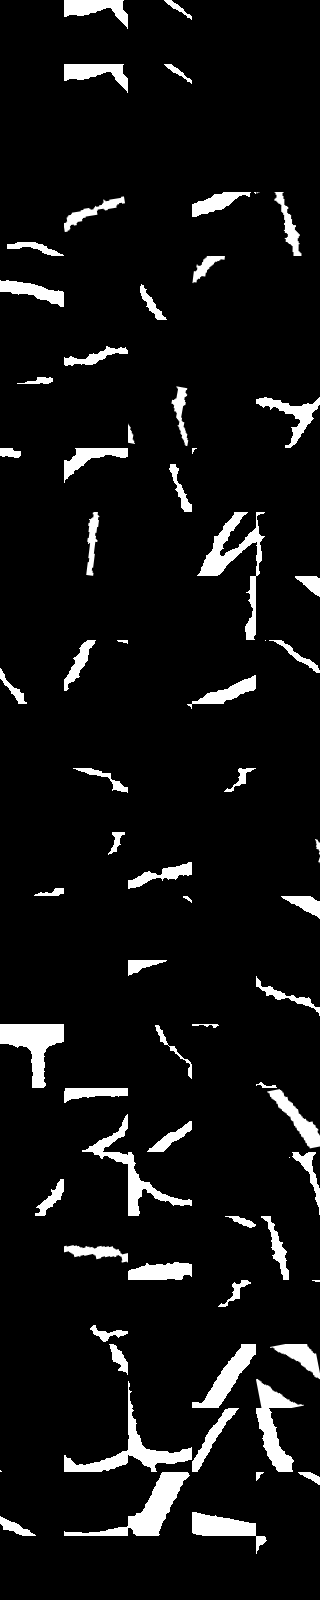

In [9]:
N_sample = min(patches_imgs_train.shape[0],120)
print(N_sample)
visualize(group_images(patches_imgs_train[0:N_sample,:,:,:],5),'./'+name_experiment+'/'+"sample_input_imgs")#.show()
visualize(group_images(patches_masks_train[0:N_sample,:,:,:],5),'./'+name_experiment+'/'+"sample_input_masks")#.show()

## Train block  
###  Fine tuning block  
U-Net fine tuning  
  |_ DRIVE dataset (Pretrained)  
  |_ Conjunctival dataset (Fine tuning)


In [10]:
name_experiment

'result/conjunctival_result/20_03_20_test01'

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [12]:
print(pretrained_dir)

20_02_25_HRF_conj_scaleTest


In [13]:
n_ch = patches_imgs_train.shape[1]
patch_height = patches_imgs_train.shape[2]
patch_width = patches_imgs_train.shape[3]

if fine_tuning_flag=="False":
    print ("entered unet")
    model = small_attn_unet(n_ch, patch_height, patch_width,2)
    #model = unet_norm(n_ch, patch_height, patch_width)  #the U-net model
    #model = model_from_json(open('./result/Retina_Result/'+ pretrained_dir + '/' + pretrained_dir +'_architecture.json').read())
    #model.load_weights('./result/Retina_Result/'+ pretrained_dir + '/' +best_last+'_weights.h5')
    
    plot(model, to_file='./'+name_experiment+'/' + '_model.png')   #check how the model looks like
    json_string = model.to_json()
    open('./'+name_experiment+'/'+'_architecture.json', 'w').write(json_string)

elif fine_tuning_flag=="True":
    # --------------------Fine tuning while training -----------------
    print ("About to load the pre trained model for fine tuning")
    model = model_from_json(open('./result/Retina_Result/'+ pretrained_dir + '/' + pretrained_dir +'_architecture.json').read())
    model.load_weights('./result/Retina_Result/'+ pretrained_dir + '/' +best_last+'_weights.h5')
    print ("loaded the pre trained model \n\n")

    
    for layer in model.layers[:]:
        if layer.name =='conv2d_11':
            layer.trainable = True
            print (layer.name,'\t',"Trainable layer")
        else :
            layer.trainable = False
        
        print (layer.name,'\t',"these layers wont be trained")
    
    ''' 
    for layer in model.layers[17:25]:
        layer.trainable = False
        print (layer.name,'\t',"these layers wont be trained")
    '''
    #sgd = SGD(lr=0.0001, momentum=0., decay=0., nesterov=False)
    adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
   # model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.compile(optimizer=adam, loss=dice_coef_loss,metrics=[dice_coef])
    
#print model.layers
print ("Check: final output of the network:")
print (model.output_shape)
print(model.summary())






entered unet
input shape :  (None, 1, 64, 64)
shape x,g  (None, 64, 16, 16) (None, 128, 8, 8)
inter shape :   64
stride x : 1 stride y : 1
theta_x shape :  (None, 64, 8, 8)
upsample_g shape :  (None, 64, 8, 8)
shape x,g  (None, 32, 32, 32) (None, 96, 16, 16)
inter shape :   32
stride x : 1 stride y : 1
theta_x shape :  (None, 32, 16, 16)
upsample_g shape :  (None, 32, 16, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 64, 64)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 64, 64)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (Batc

In [14]:
from keras.callbacks import Callback
import math

class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # 1e-9 + (1e-6 ) * (1 + cos ())
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

###  Model training block

In [15]:
'''
Keras provides a set of functions called callbacks: 
you can think of callbacks as events that will be triggered at certain training states. 
The callback we need for checkpointing is the ModelCheckpoint 
which provides all the features we need according to the checkpointing strategy we adopted in our example
'''

checkpointer = ModelCheckpoint(filepath='./'+name_experiment+'/best_weights.h5', verbose=1, monitor='loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

print('[training session] before mask unet func patch mask shape : ',patches_masks_train.shape)
patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption
print('[training session] after mask unet func patch mask shape : ',patches_masks_train.shape)

try:
    history = model.fit(patches_imgs_train, patches_masks_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.2, callbacks=[checkpointer, CosineAnnealingScheduler(T_max=150, eta_max=1e-6, eta_min=1e-8)])
    model.save_weights('./'+name_experiment +'/last_weights.h5', overwrite=True)
except KeyboardInterrupt:
    model.save_weights('./'+name_experiment +'/last_weights.h5', overwrite=True)
    print('Keyboard Interrupt')



[training session] before mask unet func patch mask shape :  (200000, 1, 64, 64)
[training session] after mask unet func patch mask shape :  (200000, 4096, 2)
Train on 160000 samples, validate on 40000 samples
Epoch 1/150
160000/160000 [==============================] - 179s 1ms/step - loss: 0.4959 - dice_coef: 0.5041 - val_loss: 0.4914 - val_dice_coef: 0.5086

Epoch 00001: loss improved from inf to 0.49592, saving model to ./result/conjunctival_result/20_03_20_test01/best_weights.h5
Epoch 2/150
160000/160000 [==============================] - 185s 1ms/step - loss: 0.4385 - dice_coef: 0.5615 - val_loss: 0.4450 - val_dice_coef: 0.5550

Epoch 00002: loss improved from 0.49592 to 0.43853, saving model to ./result/conjunctival_result/20_03_20_test01/best_weights.h5
Epoch 3/150
160000/160000 [==============================] - 186s 1ms/step - loss: 0.3870 - dice_coef: 0.6130 - val_loss: 0.3945 - val_dice_coef: 0.6055

Epoch 00003: loss improved from 0.43853 to 0.38702, saving model to ./resu

In [17]:
1e-6

1e-06

In [19]:
print(history.history)


NameError: name 'history' is not defined

In [20]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss= history.history['val_loss']
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

epochs = range(1,len(acc) +1)

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()
plt.savefig(name_experiment+"/training_loss_result.png")
plt.figure()

plt.plot(epochs, acc, 'ro', label = "Training accuracy")
plt.plot(epochs, val_acc, 'r', label = "Validation accuracy")
plt.title("Training and Validation acc")
plt.xlabel("epochs")
plt.ylabel('acc')
plt.legend()


plt.savefig(name_experiment+"/training_acc_result.png")
plt.show()

NameError: name 'history' is not defined

In [ ]:
import pandas as pd
file_path = './'+name_experiment + '/' + 'train_history'

def save_history_txt_csv(history, file_path, file_name):
    if os.path.isdir(file_path) == False:
        os.mkdir(file_path)
    else:
        print('already exist the folder in this path : {}'.format(file_path))
    
    hist_df = pd.DataFrame(history) 

    # save to json:  
    hist_json_file = file_path + '/' + file_name +'.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = file_path + '/' + file_name + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        

save_history_txt_csv(loss, file_path, 'loss')
save_history_txt_csv(acc, file_path, 'dice_coef')
